### Imports and Definitions

In [1]:
from glob import glob
from math import log10
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import makedirs
from seaborn import pointplot, set_context, set_style, violinplot
from zipfile import ZipFile
import matplotlib.pyplot as plt
ZERO_THRESH = 0.0000000001
DATADIR = '../data'
FIGDIR = '../figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot
meta = {
    'time_fn': {
        'SEQTK':                      'time.01.seqtk.subsample.txt',
        'MINIMAP2':                   'time.02.minimap2.txt',
        'SAMTOOLS_SORT_UNTRIMMED':    'time.03.samtools.sort.untrimmed.txt',
        'IVAR_TRIM':                  'time.04.ivar.trim.txt',
        'SAMTOOLS_SORT_IVAR_TRIMMED': 'time.05.samtools.sort.ivar.trimmed.txt',
        'SAMTOOLS_PILEUP':            'time.06.samtools.pileup.txt',
        'IVAR_VARIANTS':              'time.07.ivar.variants.txt',
        'IVAR_CONSENSUS':             'time.08.ivar.consensus.txt',
        'AMPLIPY_TRIM':               'time.09.amplipy.trim.txt',
        'AMPLIPY_VARIANTS':           'time.10.amplipy.variants.txt',
        'AMPLIPY_CONSENSUS':          'time.11.amplipy.consensus.txt',
        'AMPLIPY_AIO':                'time.12.amplipy.aio.txt',
        'VIRALCONSENSUS':             'time.13.viralconsensus.txt',
    },
    
    
    'label': {
        'amplipy_aio': 'AmpliPy (AIO)',
        'ivar_pipeline': 'iVar (Pipeline)',
        'ivarconsensus': 'iVar (Pipeline)',
        'viralconsensus': 'ViralConsensus',
        'illumina': 'Illumina HiSeq 2000',
        'ont': 'Oxford Nanopore Technologies (ONT)',
        'time': 'Total Runtime (s)',
        'mem': 'Peak Memory (MB)',
        'ratio_time': 'iVar/ViralConsensus Runtime Ratio',
        'ratio_mem': 'iVar/ViralConsensus Peak Memory Ratio',
    },
    
    'color': {
        'amplipy_aio': 'blue',
        'ivar_pipeline': 'red',
        'ivarconsensus': 'red',
        'viralconsensus': 'green',
        'ratio': 'black',
    },
    
    'linestyle': {
        'amplipy_aio': '--',
        'ivar_pipeline': ':',
        'ivarconsensus': ':',
        'viralconsensus': '-',
        'ratio': '-',
    },
    
    'steps': {
        'ivar_pipeline': ['SAMTOOLS_SORT_UNTRIMMED', 'IVAR_TRIM', 'SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'amplipy_aio': ['AMPLIPY_AIO'],
        'viralconsensus': ['VIRALCONSENSUS'],
        'iVar (Variants + Consensus)': ['SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'AmpliPy (Variants + Consensus)': ['AMPLIPY_VARIANTS', 'AMPLIPY_CONSENSUS'],
    },
}

### Helper: Convert Power of 10 to Scientific Notation

In [2]:
def sci_not_mult10(n):
    p = log10(n)
    assert abs(p-int(p)) < ZERO_THRESH, "Not a power of 10: %s" % n
    return r'$10^%d$' % p

### Helper: Compute Hamming Distance from Pairwise Alignment 1-line FASTA

In [3]:
def hamming(fn, normalize=True):
    x, y = [l.strip() for l in open(fn) if not l.startswith('>')]
    return sum(x[i] != y[i] for i in range(len(x)))/float(len(x))

### Helper: Parse `/usr/bin/time` Output

In [4]:
def parse_time_output(lines):
    t = None; m = None
    for l in lines:
        if l.strip().startswith('Elapsed (wall clock) time (h:mm:ss or m:ss)'):
            parts = l.split()[-1].split(':')
            if len(parts) == 3: # h:mm:ss
                t = float(parts[0])*3600 + float(parts[1])*60 + float(parts[2])
            elif len(parts) == 2: # m:ss
                t = float(parts[0])*60 + float(parts[1])
            else:
                assert False, "Invalid time: %s" % ':'.join(parts)
        elif l.strip().startswith('Maximum resident set size (kbytes)'):
            m = int(l.split()[-1]) / 1024 # store peak memory as MB instead of KB
    assert t is not None, "Failed to parse runtime"
    assert m is not None, "Failed to parse peak memory"
    return t, m

### Load Data from Zips

In [5]:
data = dict()
for z_fn in glob('%s/time_memory_benchmark/n*/n*.r*.zip' % DATADIR):
    n = int(z_fn.split('/')[-1].split('.')[0].lstrip('n'))
    r = int(z_fn.split('/')[-1].split('.')[1].lstrip('r'))
    z = ZipFile(z_fn)
    if n not in data:
        data[n] = dict()
    if r not in data[n]:
        data[n][r] = dict()
    for comp_fn in z.namelist():
        if comp_fn.startswith('time.'):
            t, m = parse_time_output(z.read(comp_fn).decode().splitlines())
            data[n][r][comp_fn] = {'time':t, 'mem':m}

### Plot Pipeline Runtime and Peak Memory vs. *n*

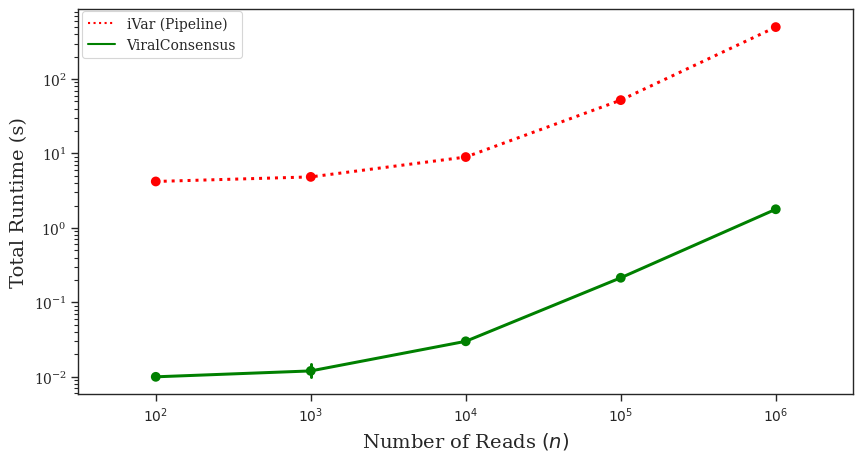

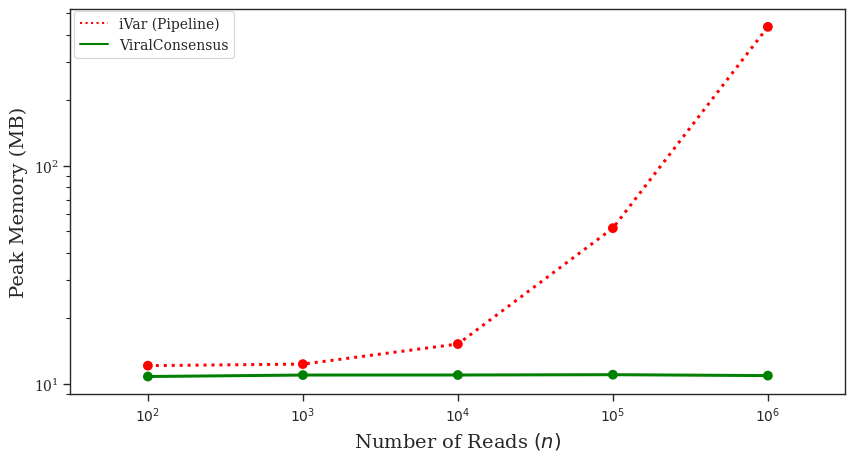

In [6]:
for plot in ['time', 'mem']:
    fig, ax = plt.subplots(figsize=(10,5)); handles = list()
    #for pipeline in ['ivar_pipeline', 'amplipy_aio', 'viralconsensus']:
    for pipeline in ['ivar_pipeline', 'viralconsensus']:
        handles.append(Line2D([0],[0],color=meta['color'][pipeline],label=meta['label'][pipeline],linewidth=1.5,linestyle=meta['linestyle'][pipeline]))
        x = list(); y = list()
        for n in sorted(data.keys()):
            for r in sorted(data[n].keys()):
                x.append(sci_not_mult10(n))
                if plot == 'time':
                    y.append(sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps'][pipeline]))
                elif plot == 'mem':
                    y.append(max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps'][pipeline]))
        pointplot(x=x, y=y, color=meta['color'][pipeline], linestyles=meta['linestyle'][pipeline])
    plt.xlabel(r'Number of Reads $\left(n\right)$')
    plt.ylabel(meta['label'][plot])
    #plt.title(meta['label'][plot])
    ax.set_yscale('log')
    plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
    fig.savefig('%s/%s.pdf' % (FIGDIR, plot), format='pdf', bbox_inches='tight')

### Plot iVar/ViralConsensus Ratio vs. *n*

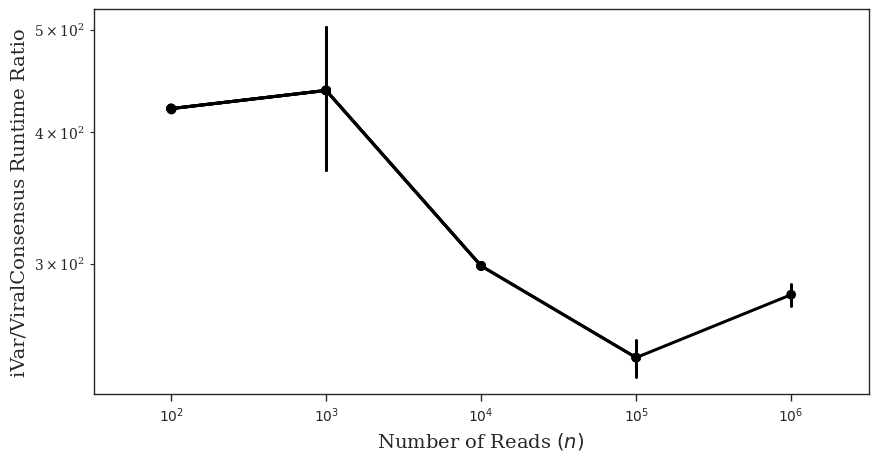

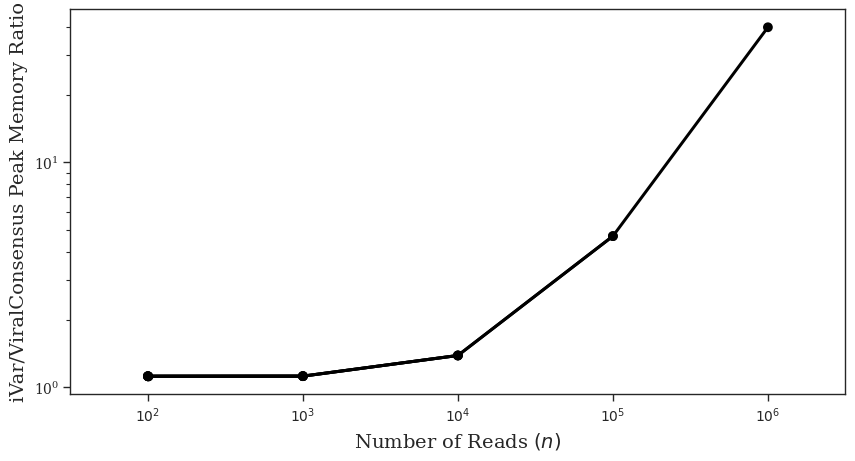

In [7]:
for plot in ['time', 'mem']:
    fig, ax = plt.subplots(figsize=(10,5)); handles = list()
    #for pipeline in ['ivar_pipeline', 'amplipy_aio']:
    x = list(); y = list()
    for n in sorted(data.keys()):
        for r in sorted(data[n].keys()):
            x.append(sci_not_mult10(n))
            if plot == 'time':
                y_a = sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['viralconsensus'])
                y_i = sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['ivar_pipeline'])
            elif plot == 'mem':
                y_a = max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['viralconsensus'])
                y_i = max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['ivar_pipeline'])
            y.append(y_i/y_a)
        pointplot(x=x, y=y, color=meta['color']['ratio'], linestyles=meta['linestyle']['ratio'])
    plt.xlabel(r'Number of Reads $\left(n\right)$')
    plt.ylabel(meta['label']['ratio_%s' % plot])
    #plt.title(meta['label']['ratio_%s' % plot])
    ax.set_yscale('log')
    fig.savefig('%s/%s.ratio.pdf' % (FIGDIR, plot), format='pdf', bbox_inches='tight')

### Plot Consensus Accuracy

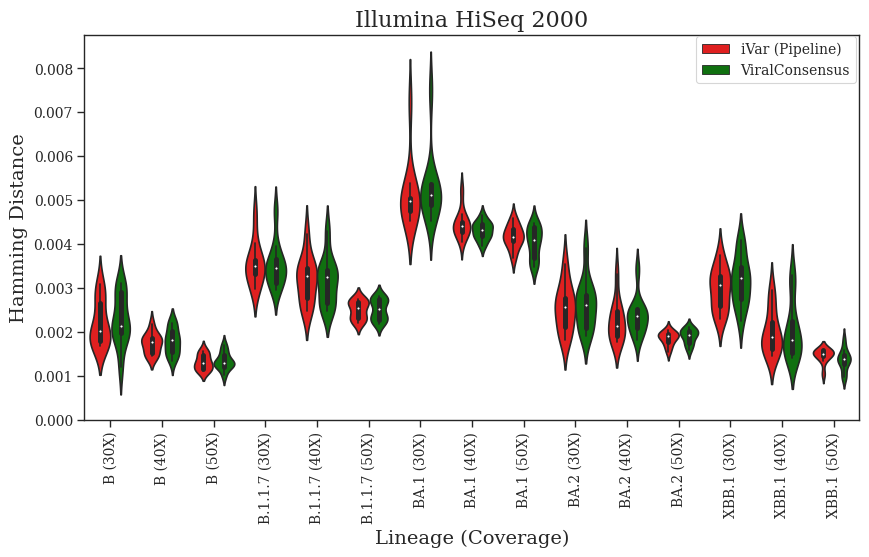

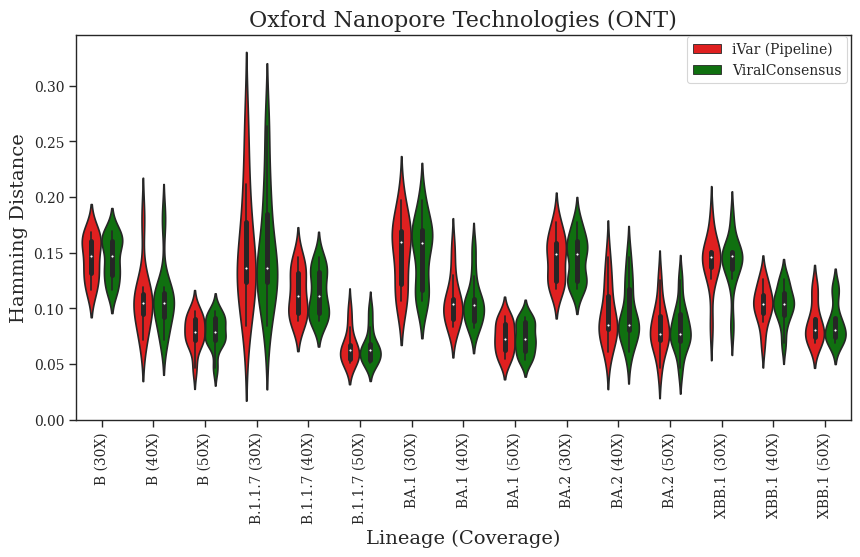

In [8]:
colors = [meta['color']['ivarconsensus'], meta['color']['viralconsensus']]
for sequencer in ['illumina', 'ont']:
    fig, ax = plt.subplots(figsize=(10,5)); x = list(); y = list(); h = list()
    for lineage in ['B', 'B.1.1.7', 'BA.1', 'BA.2', 'XBB.1']:
        for coverage in [30, 40, 50]:
            for tool in ['ivarconsensus', 'viralconsensus']:
                for aln in glob('%s/accuracy_benchmark/lineage_%s/c%d/%s/%s/*.aln' % (DATADIR, lineage, coverage, sequencer, tool)):
                    x.append("%s (%dX)" % (lineage, coverage))
                    y.append(hamming(aln))
                    h.append(meta['label'][tool])
    violinplot(x=x, y=y, hue=h, palette=colors)
    plt.legend(bbox_to_anchor=(0.995, 0.995), loc='upper right', borderaxespad=0., frameon=True)
    plt.xticks(rotation=90)
    plt.xlabel("Lineage (Coverage)")
    plt.ylabel("Hamming Distance")
    plt.ylim(ymin=0)
    plt.title(meta['label'][sequencer])
    fig.savefig('%s/accuracy.%s.pdf' % (FIGDIR, sequencer), format='pdf', bbox_inches='tight')